In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import multiprocessing as mp
from datetime import datetime
import traceback
import sys
sys.path.insert(0, '../../data/siim-pneumothorax')

import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai
from fastai.vision import *
from mask_functions import *
from fastai.callbacks import SaveModelCallback
import gc
from sklearn.model_selection import KFold
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

fastai.__version__


'1.0.54'

In [2]:
sz = 512
bs = 2
n_acc = 64//bs #gradinet accumulation steps
nfolds = 4
SEED = 2019

data_path = '../../data/siim-pneumothorax/s2'
torch.cuda.set_device('cuda:1')
os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

TRAIN = os.path.join(data_path, 'train')
VAL = os.path.join(data_path, 'val')
TEST = os.path.join(data_path, 'test')
MASK = os.path.join(data_path, 'mask')

stats = ([0.491,0.49,0.49],[0.249,0.248,0.248])
test_stats = ([0.491,0.49,0.49],[0.249,0.248,0.248])
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)

In [3]:
from fastai.vision.learner import create_head, cnn_config, num_features_model, create_head
from fastai.callbacks.hooks import model_sizes, hook_outputs, dummy_eval, Hook, _hook_inner
from fastai.vision.models.unet import _get_sfs_idxs, UnetBlock

class Hcolumns(nn.Module):
    def __init__(self, hooks:Collection[Hook], nc:Collection[int]=None):
        super(Hcolumns,self).__init__()
        self.hooks = hooks
        self.n = len(self.hooks)
        self.factorization = None 
        if nc is not None:
            self.factorization = nn.ModuleList()
            for i in range(self.n):
                self.factorization.append(nn.Sequential(
                    conv2d(nc[i],nc[-1],3,padding=1,bias=True),
                    conv2d(nc[-1],nc[-1],3,padding=1,bias=True)))
                #self.factorization.append(conv2d(nc[i],nc[-1],3,padding=1,bias=True))
        
    def forward(self, x:Tensor):
        n = len(self.hooks)
        out = [F.interpolate(self.hooks[i].stored if self.factorization is None
            else self.factorization[i](self.hooks[i].stored), scale_factor=2**(self.n-i),
            mode='bilinear',align_corners=False) for i in range(self.n)] + [x]
        return torch.cat(out, dim=1)

class DynamicUnet_Hcolumns(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, blur:bool=False, blur_final=True, 
                 self_attention:bool=False,
                 y_range:Optional[Tuple[float,float]]=None,
                 last_cross:bool=True, bottle:bool=False, sz=512, **kwargs):
        #imsize = (256,256)
        imsize = (sz, sz)
        sfs_szs = model_sizes(encoder, size=imsize)
        sfs_idxs = list(reversed(_get_sfs_idxs(sfs_szs)))
        print(sfs_szs, sfs_idxs)
        self.sfs = hook_outputs([encoder[i] for i in sfs_idxs])
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, ni*2, **kwargs),
                                    conv_layer(ni*2, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        self.hc_hooks = [Hook(layers[-1], _hook_inner, detach=False)]
        hc_c = [x.shape[1]]
        
        for i,idx in enumerate(sfs_idxs):
            not_final = i!=len(sfs_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sfs_szs[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sfs_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, 
                blur=blur, self_attention=sa, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)
            self.hc_hooks.append(Hook(layers[-1], _hook_inner, detach=False))
            hc_c.append(x.shape[1])

        ni = x.shape[1]
        if imsize != sfs_szs[0][-2:]: layers.append(PixelShuffle_ICNR(ni, **kwargs))
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(res_block(ni, bottle=bottle, **kwargs))
        hc_c.append(ni)
        layers.append(Hcolumns(self.hc_hooks, hc_c))
        layers += [conv_layer(ni*len(hc_c), n_classes, ks=1, use_activ=False, **kwargs)]
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()
            
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
        norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, 
        blur:bool=False, self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, 
        last_cross:bool=True, bottle:bool=False, cut:Union[int,Callable]=None, 
        hypercolumns=True, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    M = DynamicUnet_Hcolumns if hypercolumns else DynamicUnet
    model = to_device(M(body, n_classes=data.c, blur=blur, blur_final=blur_final,
        self_attention=self_attention, y_range=y_range, norm_type=norm_type, 
        last_cross=last_cross, bottle=bottle, sz=sz), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained: learn.freeze()
    apply_init(model[2], nn.init.kaiming_normal_)
    return learn

In [4]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    #input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [5]:
#dice for threshold selection
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [6]:
def dice_sample_detail(pred, targ):
    pred = pred.view(-1)
    targ = targ.view(-1)
    
    intersect = (pred * targ).sum(-1).float()
    union = (pred + targ).sum(-1).float()
    
    if pred.sum() == 0: # tn + fn
        if targ.sum() == 0:
            result = 'tn'
            dice = 1.
        else:
            result = 'fn'
            dice = 0.
    else: # tp + fp
        if targ.sum() == 0:
            result = 'fp'
            dice = 0.
        else:
            result = 'tp'
            dice = 2. * intersect / union
            
    return dice, result

In [7]:
def dice_overall_detail(preds, targs):
    n = preds.shape[0]
    dices = []
    
    tp = []
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(n):
        dice, result = dice_sample_detail(preds[i], targs[i])
        
        dices.append(dice)
        
        if result == 'tp':
            tp.append(dice)
        elif result == 'tn':
            tn += 1
        elif result == 'fp':
            fp += 1
        elif result == 'fn':
            fn += 1
            
    return dices, tp, tn, fp, fn

In [8]:
def dice_overall_detail_step(preds, targs):
    n = preds.shape[0]
    dices = []
    
    tp = []
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(n):
        dice, result = dice_sample_detail(preds[i].cuda(), targs[i].cuda())
        
        dices.append(dice)
        
        if result == 'tp':
            tp.append(dice)
        elif result == 'tn':
            tn += 1
        elif result == 'fp':
            fp += 1
        elif result == 'fn':
            fn += 1
            
    return dices, tp, tn, fp, fn

In [9]:
def get_preds(learn, ds_type=DatasetType.Valid):
    preds = []
    ys = []
    
    model = learn.model
    model.eval()
    
    dl = learn.dl(ds_type)
    
    with torch.no_grad():
        for xb, yb in progress_bar(dl):
            pred = model(xb)
            pred = F.softmax(pred, dim=1)
            
            preds.append(to_detach(pred))
            ys.append(yb.cpu())
            
    del pred
    gc.collect()
    torch.cuda.empty_cache()
    
    return torch.cat(preds),torch.cat(ys)

In [10]:
# Prediction with flip TTA
def pred_with_flip(learn:fastai.basic_train.Learner,
                   ds_type:fastai.basic_data.DatasetType=DatasetType.Valid):
    #get prediction
    # preds, ys = learn.get_preds(ds_type)
    preds, ys = get_preds(learn, ds_type)
    preds = preds[:,1,...]
    
    preds = preds.cpu()
    ys = ys.cpu()
    
    #add fiip to dataset and get prediction
    learn.data.dl(ds_type).dl.dataset.tfms.append(flip_lr())
    preds_lr, ys = get_preds(learn, ds_type)
    
    del learn.data.dl(ds_type).dl.dataset.tfms[-1]
    
    preds_lr = preds_lr[:,1,...].cpu()
    ys = ys.squeeze().cpu()
    
    preds = 0.5*(preds + torch.flip(preds_lr,[-1]))
    
    del preds_lr
    
    gc.collect()
    torch.cuda.empty_cache()
    
    return preds, ys

In [11]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [12]:
def get_data():
    # Create databunch
    data = (SegmentationItemList.from_folder(data_path)
            .split_by_folder(train='train', valid='val')
            #.label_from_func(lambda x : str(x).replace('train', 'mask') if str(x).find('train') > -1 else str(x).replace('val', 'mask'), classes=[0,1])
            .label_from_func(lambda x : str(x).replace('train', 'mask') if str(x).find('train') > -1 else str(x).replace('val', 'mask'), classes=[0,1])
            .add_test(Path(TEST).ls(), label=None)
            .transform(get_transforms(), size=sz, tfm_y=True)
            .databunch(path=Path('.'), bs=bs)
            .normalize(stats))
    return data

### common config

In [13]:
tag = '20190729-122311_512'
self_attention = True

## S1 Eval

In [14]:
for fold in range(nfolds):
    print('fold: ', fold)

    data = get_data()

    # load pretrained model
    learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=self_attention)
    learn.load('hc_{}_fold{}'.format(tag, fold))

    #prediction on val and test sets
    preds, ys = pred_with_flip(learn)
    
    # save preds and ys
    torch.save(preds.cpu(), 'hc_preds_{}_fold{}.pth'.format(tag, fold))
    torch.save(ys.cpu(), 'hc_ys_{}_fold{}.pth'.format(tag, fold))

    # clean up
    if fold != nfolds-1: 
        del learn, data

    gc.collect()
    torch.cuda.empty_cache()

fold:  0
[torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 64, 64]), torch.Size([1, 64, 64, 64]), torch.Size([1, 128, 32, 32]), torch.Size([1, 256, 16, 16]), torch.Size([1, 512, 8, 8])] [6, 5, 4, 2]


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


KeyboardInterrupt: 

fold:  0


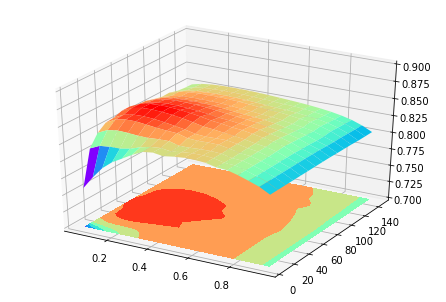

max_score: 0.8507528643751022, best_thr: 0.2, best_n_thr: 65
fold:  1


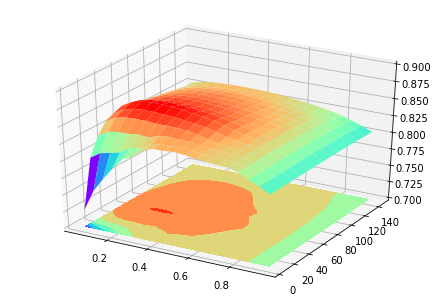

max_score: 0.8606702315800283, best_thr: 0.25, best_n_thr: 55
fold:  2


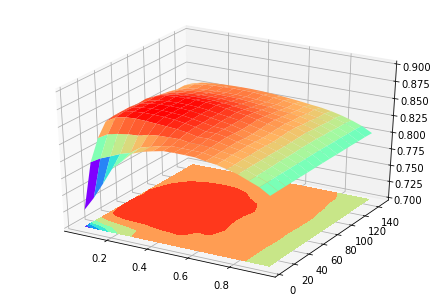

max_score: 0.8522620274476251, best_thr: 0.25, best_n_thr: 65
fold:  3


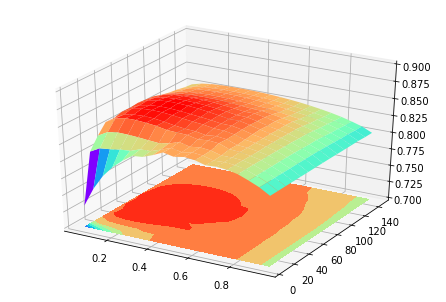

max_score: 0.8500501794018307, best_thr: 0.2, best_n_thr: 75


In [15]:
# grid search

best_scores = []
best_n_thrs = []
best_thrs = []

for fold in range(nfolds):
    print('fold: ', fold)
    
    # load preds and ys
    preds = torch.load('hc_preds_{}_fold{}.pth'.format(tag, fold))
    ys = torch.load('hc_ys_{}_fold{}.pth'.format(tag, fold))
    
    scores = []
    thrs = np.arange(0.05, 1, 0.05)
    n_thrs = np.arange(5, 150, 10)
    
    for n_th in progress_bar(n_thrs):
        preds_clean = preds.clone()
        ys = ys.float().cuda()
        
        preds_clean[preds_clean.view(preds_clean.shape[0], -1).sum(-1) < n_th*(sz/128.0)**2,...] = 0.0
        
        dice_clean = []
        for thr in progress_bar(thrs):
            preds_cpu = (preds_clean>thr).float()
            
            dices, tp, tn, fp, fn = dice_overall_detail_step(preds_cpu, ys)    
            dice_clean.append(np.mean(dices))
            
        scores.append(dice_clean)
    scores = np.array(scores)
    
    # plot grid surface
    X, Y = np.meshgrid(thrs, n_thrs)

    fig = plt.figure()
    ax = Axes3D(fig)

    ax.plot_surface(X, Y, scores, cmap='rainbow')
    ax.contourf(X, Y, scores, zdir='z', offset=0.7, cmap='rainbow')
    ax.set_zlim(0.7, 0.9)

    plt.show()
    
    # print result
    max_score = np.max(scores)
    n_thr_idx, thr_idx = np.unravel_index(np.argmax(scores), scores.shape)
    
    best_scores.append(max_score)
    best_n_thrs.append(n_thrs[n_thr_idx])
    best_thrs.append(thrs[thr_idx])

    print('max_score: {}, best_thr: {}, best_n_thr: {}'.format(max_score, thrs[thr_idx], n_thrs[n_thr_idx]))

In [16]:
print('scores: ', best_scores)
print('mean score: ', np.array(best_scores).mean())

print('thresholds: ', best_thrs)
best_thr = np.array(best_thrs).mean()
print('best threshold: ', best_thr)

print('noise thrs: ', best_n_thrs)
best_n_thr = np.array(best_n_thrs).mean()
print('best noise threshold: ', best_n_thr)

scores:  [0.8507528643751022, 0.8606702315800283, 0.8522620274476251, 0.8500501794018307]
mean score:  0.8534338257011466
thresholds:  [0.2, 0.25, 0.25, 0.2]
best threshold:  0.22499999999999998
noise thrs:  [65, 55, 65, 75]
best noise threshold:  65.0


## S2 Test

In [14]:
for fold in range(nfolds):
    print('fold: ', fold)
    
    data = get_data()
    
    # load pretrained model
    learn = unet_learner(data, models.resnet34, metrics=[dice], self_attention=self_attention)
    learn.load('hc_{}_fold{}'.format(tag, fold))
    
    #prediction on val and test sets
    pt, _ = pred_with_flip(learn, DatasetType.Test)
    
    torch.save(pt.cpu(), 'hc_pt_{}_fold{}.pth'.format(tag, fold))
    
    # clean up
    if fold != nfolds-1: 
        del learn, data
    
    gc.collect()
    torch.cuda.empty_cache()

fold:  0
[torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 128, 64, 64]), torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])] [6, 5, 4, 2]


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  1
[torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 128, 64, 64]), torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])] [6, 5, 4, 2]


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  2
[torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 128, 64, 64]), torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])] [6, 5, 4, 2]


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


fold:  3
[torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 256, 256]), torch.Size([1, 64, 128, 128]), torch.Size([1, 64, 128, 128]), torch.Size([1, 128, 64, 64]), torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])] [6, 5, 4, 2]


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DynamicUnet_Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Hcolumns. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
# load pt and average

folds = [0, 1, 2, 3]
fold_count = 0

for fold in folds:
    pt = torch.load('hc_pt_{}_fold{}.pth'.format(tag, fold))
    
    if fold_count == 0:
        ptt = pt
    else:
        ptt += pt
        
    fold_count += 1
        
ptt /= fold_count
print(ptt.shape)

torch.Size([3205, 512, 512])


In [18]:
# read test ids from sample submission file
# do NOT read from file list, since there're some non-diagnostic files

test_ids = [o.stem for o in get_data().test_ds.items]

sample_df = pd.read_csv(os.path.join(data_path, "stage_2_sample_submission.csv"))
sample_ids = list(sample_df.drop_duplicates('ImageId', keep='last').reset_index(drop=True)['ImageId'])

ids = []
ptt_filter = []

for i, sid in enumerate(test_ids):
    if sid in sample_ids:
        ids.append(sid)
        ptt_filter.append(ptt[i])
        
ptt = torch.stack(ptt_filter)
print(ptt.shape)

torch.Size([3205, 512, 512])


In [19]:
# noise removal

best_n_thr = 65.0
print('best_n_thr: {}'.format(best_n_thr))

pt_clean = ptt.clone()
pt_clean[pt_clean.view(pt_clean.shape[0],-1).sum(-1) < best_n_thr*(sz/128.0)**2,...] = 0.0
print(pt_clean.shape)

best_n_thr: 65.0
torch.Size([3205, 512, 512])


In [20]:
# hard mask

best_thr = 0.22499999999999998
print('beat_thr: {}'.format(best_thr))

pt_mask = (pt_clean[:,...]>best_thr).long()

beat_thr: 0.22499999999999998


In [21]:
n = pt_mask.shape[0]
m = pt_mask.float().view(n, -1)
m = m.sum(-1)
m[m[:,...]>0.] = 1.

print('area: {}, positive: {}'.format(pt_mask.sum(), m.sum().long()))

area: 2304595, positive: 467


In [22]:
# Generate rle encodings in parallel (images are first converted to the original size)
#print(pt_mask)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)

    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rle_list = pool.map(mask_worker, pt_mask.numpy())

In [23]:
# ok, export submission csv

sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rle_list})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'

sub_df.to_csv('hc_sub_{}.csv'.format(tag), index=False)

sub_df.head(20)

,ImageId,EncodedPixels
0,ID_d5ba67b26,-1
1,ID_bf0650b32,-1
2,ID_02607293d,43810 64 960 64 946 96 928 96 922 108 916 108 ...
3,ID_b225e343c,223368 6 1018 6 1016 8 1016 8 1016 8 1016 8 10...
4,ID_c4ae06ed9,-1
5,ID_0efca2a02,-1
6,ID_de0ef3c02,-1
7,ID_65bbff157,131340 64 960 64 946 84 940 84 932 96 928 96 9...
8,ID_500017f47,284910 8 1016 8 1014 8 1016 8 13282 8 1016 8 1...
9,ID_26868d817,-1


In [24]:
cls_rles = ['-1' if rle != '' else '1 2' for rle in rle_list]
cls_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': cls_rles})
cls_df.loc[cls_df.EncodedPixels=='', 'EncodedPixels'] = '1 2'
cls_df.to_csv('hc_{}_{}folds_cls.csv'.format(tag, nfolds), index=False)
cls_df.head()

,ImageId,EncodedPixels
0,ID_d5ba67b26,1 2
1,ID_bf0650b32,1 2
2,ID_02607293d,-1
3,ID_b225e343c,-1
4,ID_c4ae06ed9,1 2
